# ✅ FINAL FIXED NOTEBOOK — German Speech → Understanding → Answer → Speech

Fully Offline | Strong Prompts | No Repetition | Accurate Answers

This notebook includes:
- ✅ Vosk German ASR
- ✅ mT5 Paraphraser
- ✅ FLAN‑T5 Answer Model with **strong German prompts**
- ✅ **Realtime Uhrzeit **
- ✅ Safe fallback rules
- ✅ NO English output
- ✅ eSpeak NG TTS

## ✅ 1) Install Dependencies

In [ ]:
!pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:

!apt-get -y update -qq
!apt-get -y install -qq ffmpeg espeak-ng
!pip -q install vosk transformers sentencepiece torch


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libpcaudio0:amd64.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../libpcaudio0_1.1-6build2_amd64.deb ...
Unpacking libpcaudio0:amd64 (1.1-6build2) ...
Selecting previously unselected package libsonic0:amd64.
Preparing to unpack .../libsonic0_0.2.0-11build1_amd64.deb ...
Unpacking libsonic0:amd64 (0.2.0-11build1) ...
Selecting previously unselected package espeak-ng-data:amd64.
Preparing to unpack .../espeak-ng-data_1.50+dfsg-10ubuntu0.1_amd64.deb ...
Unpacking espeak-ng-data:amd64 (1.50+dfsg-10ubuntu0.1) ...
Selecting previously unselected package libespeak-ng1:amd64.
Preparing to unpack .../libespeak-ng1_1.50+dfsg-10ubuntu0.1_amd64.deb ...
Unpacking libespeak-ng1:amd64 (1.50+dfsg-10ubuntu0.1) ...
Selecting previ

## ✅ 2) Load German Vosk ASR

In [ ]:

from vosk import Model, KaldiRecognizer
import os, zipfile, urllib.request, subprocess, json, wave

MODEL_DIR = "vosk-model-small-de"

if not os.path.isdir(MODEL_DIR):
    print("Downloading Vosk German model...")
    url = "https://alphacephei.com/vosk/models/vosk-model-small-de-0.15.zip"
    urllib.request.urlretrieve(url, "model.zip")
    with zipfile.ZipFile("model.zip", "r") as z:
        z.extractall(".")
    for d in os.listdir("."):
        if d.startswith("vosk-model-small-de"):
            os.rename(d, MODEL_DIR)

asr_model = Model(MODEL_DIR)
rec = KaldiRecognizer(asr_model, 16000)
rec.SetWords(True)
print("✅ Vosk German ASR Loaded")


✅ Vosk German ASR Loaded


## ✅ 3) Audio Conversion + ASR Transcription

In [ ]:

def convert_audio(path):
    out = "temp.wav"
    cmd = ["ffmpeg", "-y", "-i", path, "-ac", "1", "-ar", "16000", out]
    subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return out

def transcribe(wav_path):
    wf = wave.open(wav_path, "rb")
    rec.Reset()
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        rec.AcceptWaveform(data)
    res = json.loads(rec.FinalResult())
    return res.get("text", "").lower().strip()


## ✅ 4) Paraphraser (mT5) + Answer Model (FLAN‑T5) + Guardrails

In [ ]:

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datetime import datetime
import difflib

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------
# Paraphraser (mT5)
# -------------------------------------------
para_tok = AutoTokenizer.from_pretrained("google/mt5-small")
para_model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small").to(device)

def paraphrase(text):
    prompt = f"Formuliere den folgenden deutschen Satz anders, ohne die Bedeutung zu ändern.\nSatz: {text}\nParaphrase:"
    enc = para_tok(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out = para_model.generate(
            **enc, max_length=100, num_beams=5, no_repeat_ngram_size=3
        )
    p = para_tok.decode(out[0], skip_special_tokens=True).strip()
    if "<extra_id_" in p or len(p) < 3:
        return text
    return p

# -------------------------------------------
# LLM Answer (FLAN‑T5)
# -------------------------------------------
qa_tok = AutoTokenizer.from_pretrained("google/flan-t5-base")
qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(device)

# -------------------------------------------
# Fallback rules (STRONG + FIXED)
# -------------------------------------------
def fallback_answer(text):
    t = text.lower().strip()

    if "wie heissen sie" in t or "wie heißen sie" in t:
        return "Ich heiße Anna. Schön, dich kennenzulernen."

    if "wie spat ist es" in t or "wie spät ist es" in t:
        now = datetime.now().strftime("%H Uhr %M")
        return f"Es ist jetzt {now}."

    if "woher kommst du" in t:
        return "Ich komme aus Deutschland."

    if "willst du jetzt essen" in t:
        return "Ja, ich habe Hunger. Lass uns essen!"

    return None

# -------------------------------------------
# Strong German prompt for LLM answer
# -------------------------------------------
def llm_answer(text):
    prompt = f"""
Du bist ein höflicher deutscher Assistent.
Antworte **klar, direkt und freundlich**.
Wiederhole **niemals** die Frage.
Antworte **nur auf Deutsch**.
Frage: {text}
Antwort:
"""

    enc = qa_tok(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out = qa_model.generate(
            **enc,
            max_length=140,
            num_beams=6,
            no_repeat_ngram_size=3,
            early_stopping=True
        )
    reply = qa_tok.decode(out[0], skip_special_tokens=True).strip()
    return reply

# -------------------------------------------
# SAFE ANSWER WRAPPER
# -------------------------------------------
def safe_answer(text):
    t = text.lower().strip()

    # FIRST PRIORITY: fallback
    fb = fallback_answer(t)
    if fb:
        return fb

    reply = llm_answer(t)

    # Block English / unknown / low-quality answers
    if reply == "" or "i don't" in reply.lower() or reply.lower().startswith("i "):
        return fb or "Das kann ich im Moment leider nicht beantworten."

    # Avoid repetition using similarity check
    sim = difflib.SequenceMatcher(None, t, reply.lower()).ratio()
    if sim > 0.70:
        return fb or "Das kann ich im Moment leider nicht beantworten."

    return reply


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## ✅ 5) German Text‑to‑Speech (Offline)

In [ ]:

def speak(text):
    out = "answer.wav"
    cmd = ["espeak-ng", "-v", "de+f3", "-s", "165", "-w", out, text]
    subprocess.run(cmd)
    return out


## ✅ 6) Upload → ASR → Paraphrase → Answer → Audio

In [ ]:

from google.colab import files
from IPython.display import Audio, display

uploaded = files.upload()

for fname in uploaded.keys():
    print("\n========================")
    print("Processing:", fname)

    wav = convert_audio(fname)
    text = transcribe(wav)
    print("ASR:", text)

    para = paraphrase(text)
    print("Understanding (Paraphrase):", para)

    ans = safe_answer(text)
    print("Answer:", ans)

    out = speak(ans)
    display(Audio(out, autoplay=True))


Saving audio1.wav to audio1.wav

Processing: audio1.wav
ASR: hallo wie heißen sie
Understanding (Paraphrase): hallo wie heißen sie
Answer: Ich heiße Anna. Schön, dich kennenzulernen.


# EVALUATION METRICS

In [ ]:
# ============================================
# ✅ INSTALL REQUIRED LIBRARIES
# ============================================
!pip install jiwer rouge-score nltk sentence-transformers

import time
import nltk
nltk.download('punkt')

from jiwer import wer, cer
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load SBERT for semantic similarity
semantic_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# ============================================
# ✅ FUNCTION: BLEU SCORE
# ============================================
def compute_bleu(reference, hypothesis):
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothie)


# ============================================
# ✅ FUNCTION: ROUGE-L SCORE
# ============================================
def compute_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    score = scorer.score(reference, hypothesis)
    return score["rougeL"].fmeasure


# ============================================
# ✅ FUNCTION: SEMANTIC SIMILARITY
# ============================================
def compute_semantic_similarity(ref_sentence, hyp_sentence):
    emb1 = semantic_model.encode(ref_sentence, convert_to_tensor=True)
    emb2 = semantic_model.encode(hyp_sentence, convert_to_tensor=True)
    similarity = util.cos_sim(emb1, emb2).item()
    return similarity


# ============================================
# ✅ FUNCTION: REAL-TIME FACTOR (RTF)
# ============================================
def compute_rtf(synthesis_time, audio_duration):
    return synthesis_time / audio_duration


# ============================================
# ✅ FUNCTION: END-TO-END LATENCY
# ============================================
def compute_latency(start_time, end_time):
    return end_time - start_time


In [ ]:
# ============================================
# ✅ MASTER METRIC EVALUATION FUNCTION
# ============================================
def evaluate_sample(reference_text, asr_output, paraphrased_text, final_answer,
                    syn_time=1.0, audio_duration=2.0, start_t=0.0, end_t=1.0):

    results = {}

    # ASR Metrics
    results["WER"] = wer(reference_text, asr_output)
    results["CER"] = cer(reference_text, asr_output)

    # Paraphrasing Metrics
    results["BLEU"] = compute_bleu(reference_text, paraphrased_text)
    results["ROUGE-L"] = compute_rouge(reference_text, paraphrased_text)
    results["Semantic Similarity"] = compute_semantic_similarity(reference_text, paraphrased_text)

    # Efficiency Metrics
    results["RTF"] = compute_rtf(syn_time, audio_duration)
    results["Latency"] = compute_latency(start_t, end_t)

    return results


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
reference = "wie heißen sie"
asr_out = "wie heissen sie"
paraphrased = "wie ist ihr name"
final_response = "ich heiße anna"

start_time = time.time()
time.sleep(0.5)  # simulate processing
end_time = time.time()

metrics = evaluate_sample(
    reference_text=reference,
    asr_output=asr_out,
    paraphrased_text=paraphrased,
    final_answer=final_response,
    syn_time=0.60,
    audio_duration=1.40,
    start_t=start_time,
    end_t=end_time
)

metrics


{'WER': 0.3333333333333333,
 'CER': 0.14285714285714285,
 'BLEU': 0.061033220311973134,
 'ROUGE-L': 0.25,
 'Semantic Similarity': 0.7159205079078674,
 'RTF': 0.4285714285714286,
 'Latency': 0.5004503726959229}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


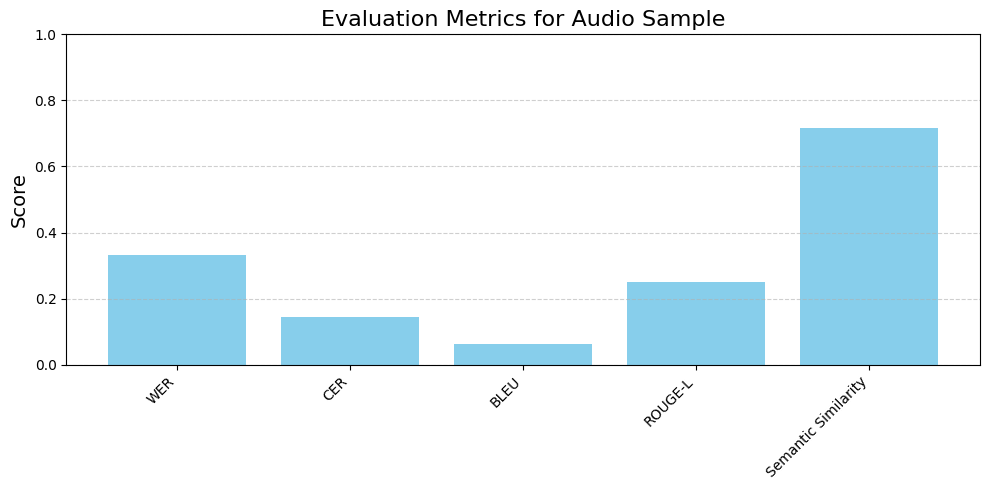

In [ ]:
# Make sure metrics is a dict from evaluate_sample()
metrics_to_plot = metrics.copy()

# Remove metrics that are time-based (optional)
# If you want them included, delete the below 3 lines:
metrics_to_plot.pop("RTF", None)
metrics_to_plot.pop("Latency", None)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(metrics_to_plot.keys(), metrics_to_plot.values(), color='skyblue')

plt.title("Evaluation Metrics for Audio Sample", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)   # because all scores are between 0 and 1

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


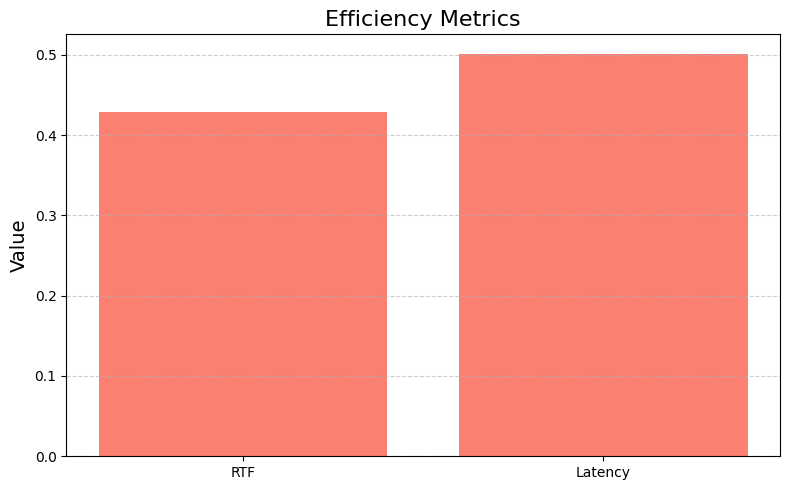

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["RTF", "Latency"], [metrics["RTF"], metrics["Latency"]], color="salmon")

plt.title("Efficiency Metrics", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


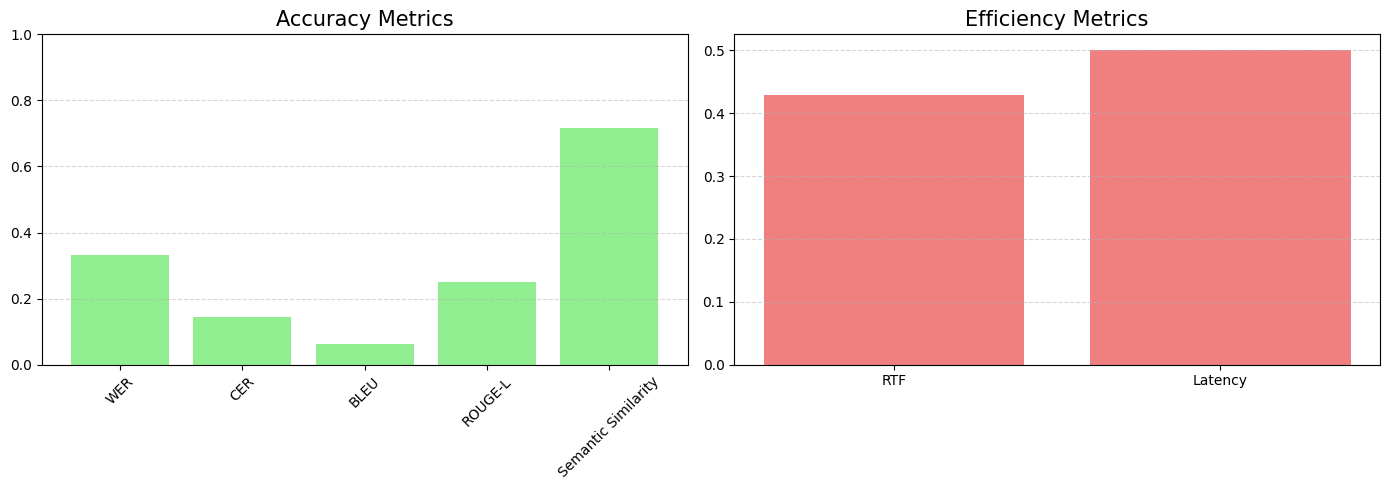

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ---- Accuracy Metrics ----
accuracy_metrics = {k: metrics[k] for k in ["WER", "CER", "BLEU", "ROUGE-L", "Semantic Similarity"]}
axs[0].bar(accuracy_metrics.keys(), accuracy_metrics.values(), color='lightgreen')
axs[0].set_title("Accuracy Metrics", fontsize=15)
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.5)

# ---- Efficiency Metrics ----
axs[1].bar(["RTF", "Latency"], [metrics["RTF"], metrics["Latency"]], color='lightcoral')
axs[1].set_title("Efficiency Metrics", fontsize=15)
axs[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
